In [1]:
# Run in a Jupyter notebook / Colab
# If you want to download directly from Kaggle inside Colab:
# pip install opendatasets
# import opendatasets as od
# od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting')

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)


# Load the data

In [2]:
# adjust the paths to where your files are
train = pd.read_csv('train.csv', parse_dates=['Date'])
features = pd.read_csv('features.csv', parse_dates=['Date'])
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv', parse_dates=['Date'])

print("Train:", train.shape)
print("Features:", features.shape)
print("Stores:", stores.shape)
print("Test:", test.shape)

train.head()


Train: (421570, 5)
Features: (8190, 12)
Stores: (45, 3)
Test: (115064, 4)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Explanation: train.csv includes Store, Dept, Date, Weekly_Sales, IsHoliday. features.csv contains weekly covariates (temperature, fuel price, CPI, unemployment, markdowns, IsHoliday). stores.csv has store info (Type, Size).

# Merge datasets into a single denormalized DataFrame

In [3]:
# merge train + features (on Store + Date)
df = pd.merge(train, features, on=['Store','Date','IsHoliday'], how='left', suffixes=('','_feat'))

# merge stores (on Store)
df = pd.merge(df, stores, on='Store', how='left')

# quick sanity
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


This makes it easy to analyze sales along with temperature, CPI, markdowns, store type/size, etc.

# Preprocessing & feature engineering

In [4]:
# ensure datetime
df['Date'] = pd.to_datetime(df['Date'])

# create date components
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)

# check missing values
df.isna().sum()


,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270889
MarkDown2,310322
MarkDown3,284479


Deal with missing features (markdowns often NA), either fill with 0 (no markdown) or forward/backfill depending on your logic:

In [5]:
md_cols = [c for c in df.columns if 'Mark' in c or 'MarkDown' in c]
for c in md_cols:
    df[c] = df[c].fillna(0)


# Create aggregate time series (weekly → monthly)

The Kaggle data is weekly; your task asked “monthly sales” — we resample weekly Weekly_Sales to monthly sums/means.

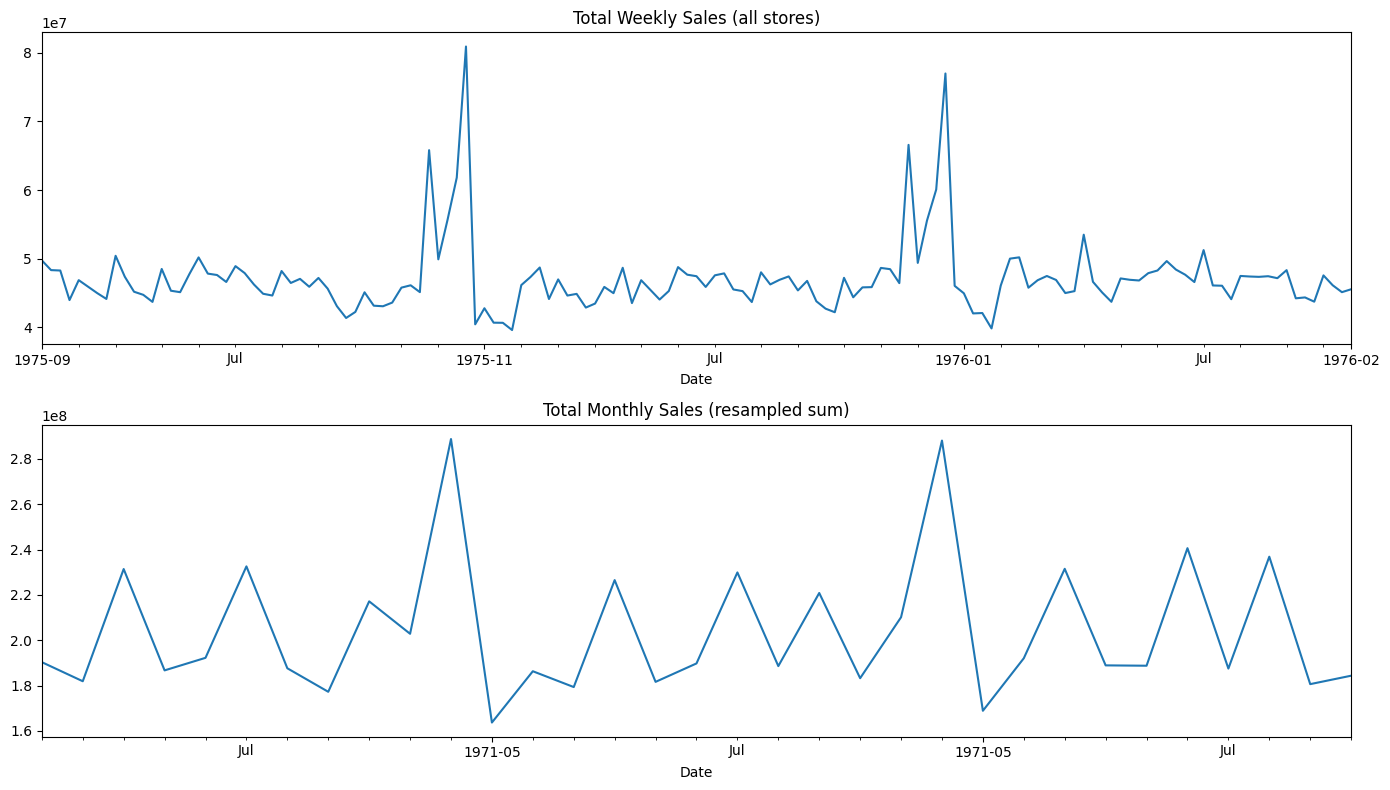

In [6]:
# make an overall store-aggregated weekly series
weekly_total = df.groupby('Date')['Weekly_Sales'].sum().sort_index()

# resample to monthly (end of month). Sum of weekly sales in that month.
monthly_total = weekly_total.resample('M').sum()

# also create monthly average (per-week average within month)
monthly_avg_weekly = weekly_total.resample('M').mean()

# quick plots
fig, ax = plt.subplots(2,1, figsize=(14,8))
weekly_total.plot(ax=ax[0], title='Total Weekly Sales (all stores)')
monthly_total.plot(ax=ax[1], title='Total Monthly Sales (resampled sum)')
ax[0].xaxis.set_major_formatter(DateFormatter('%Y-%m'))
ax[1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.tight_layout()


# Trend & seasonality analysis

Moving averages

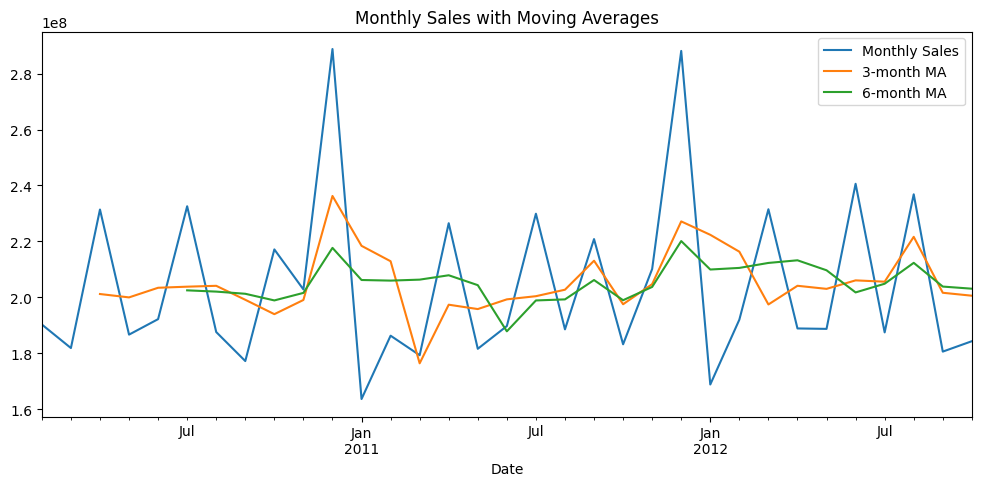

In [7]:
monthly_total_ma3 = monthly_total.rolling(window=3).mean()
monthly_total_ma6 = monthly_total.rolling(window=6).mean()

plt.figure(figsize=(12,5))
monthly_total.plot(label='Monthly Sales')
monthly_total_ma3.plot(label='3-month MA')
monthly_total_ma6.plot(label='6-month MA')
plt.legend()
plt.title('Monthly Sales with Moving Averages')
plt.show()


Seasonal decomposition

Choose period=12 for monthly data (seasonal period = 12 months). If working weekly, use period=52.

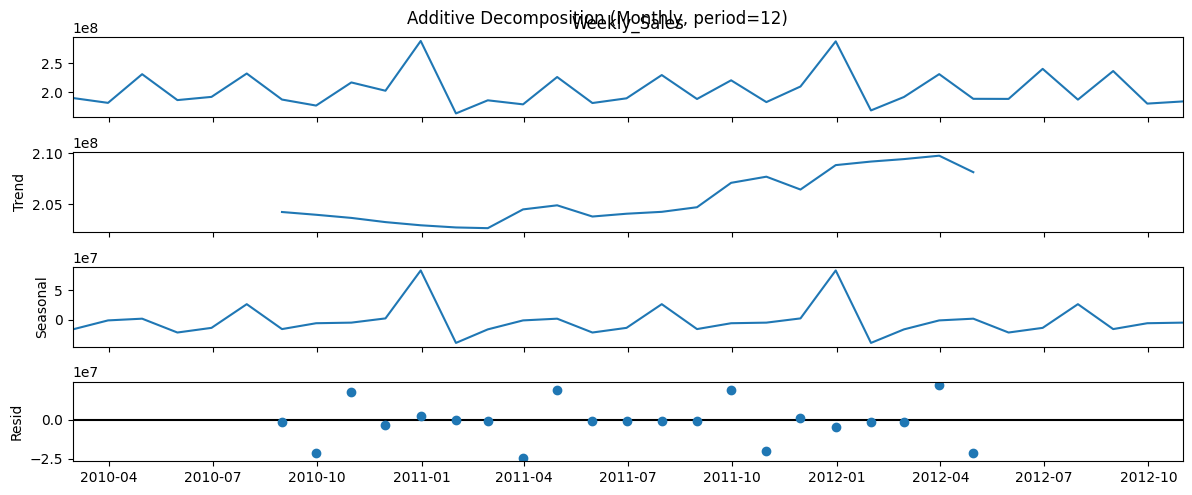

In [8]:
decomp = seasonal_decompose(monthly_total, model='additive', period=12)
decomp.plot()
plt.suptitle('Additive Decomposition (Monthly, period=12)')
plt.show()


Interpretation: decomposition shows trend, seasonal pattern (months with systematically higher/lower sales), residuals (irregular).

Month-of-year heatmap (seasonality)

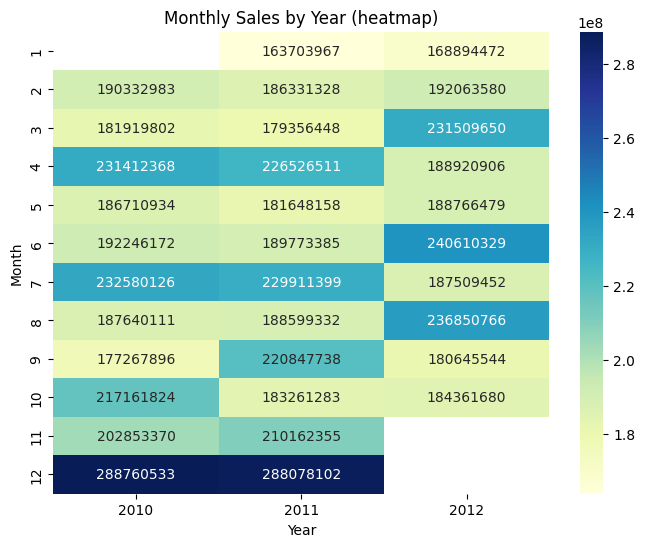

In [9]:
monthly = df.set_index('Date').groupby([pd.Grouper(freq='M')])['Weekly_Sales'].sum().rename('monthly_sales')
monthly = monthly.to_frame().reset_index()
monthly['Year'] = monthly['Date'].dt.year
monthly['Month'] = monthly['Date'].dt.month

pivot = monthly.pivot_table(index='Month', columns='Year', values='monthly_sales')
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Monthly Sales by Year (heatmap)')
plt.show()


This helps identify months with recurring peaks (e.g., holiday months).

# Breakdown by product (department) and region (store)

Top departments by total sales

In [10]:
dept_sales = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
top_depts = dept_sales.head(10)
print("Top 10 departments:\n", top_depts)


Top 10 departments:
 Dept
92    4.839433e+08
95    4.493202e+08
38    3.931181e+08
72    3.057252e+08
90    2.910685e+08
40    2.889360e+08
2     2.806112e+08
91    2.167817e+08
13    1.973216e+08
8     1.942808e+08
Name: Weekly_Sales, dtype: float64


Plot top K departments over time:

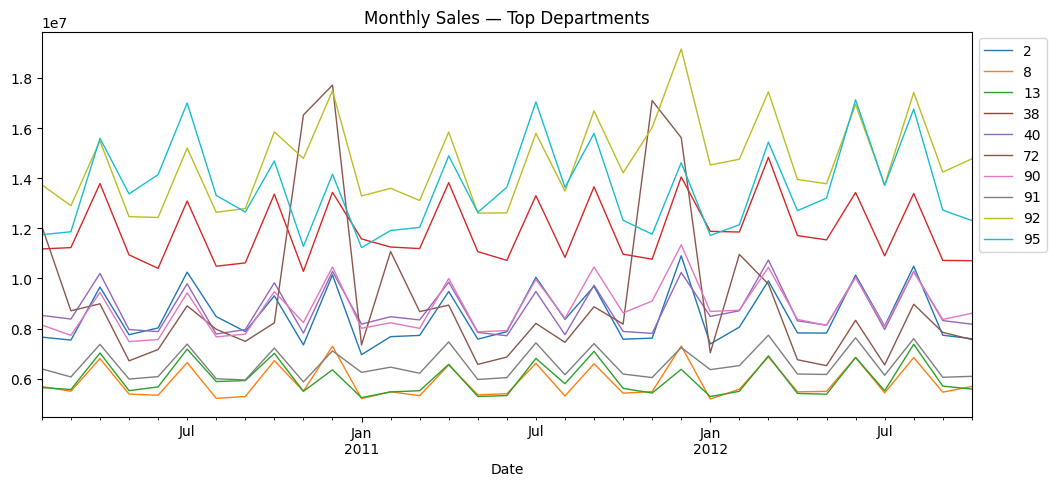

In [11]:
topk = top_depts.index.tolist()
df_topk = df[df['Dept'].isin(topk)].groupby(['Date','Dept'])['Weekly_Sales'].sum().unstack('Dept').fillna(0)
df_topk_resampled = df_topk.resample('M').sum()

df_topk_resampled.plot(subplots=False, linewidth=1)
plt.title('Monthly Sales — Top Departments')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()


Sales by store type / size

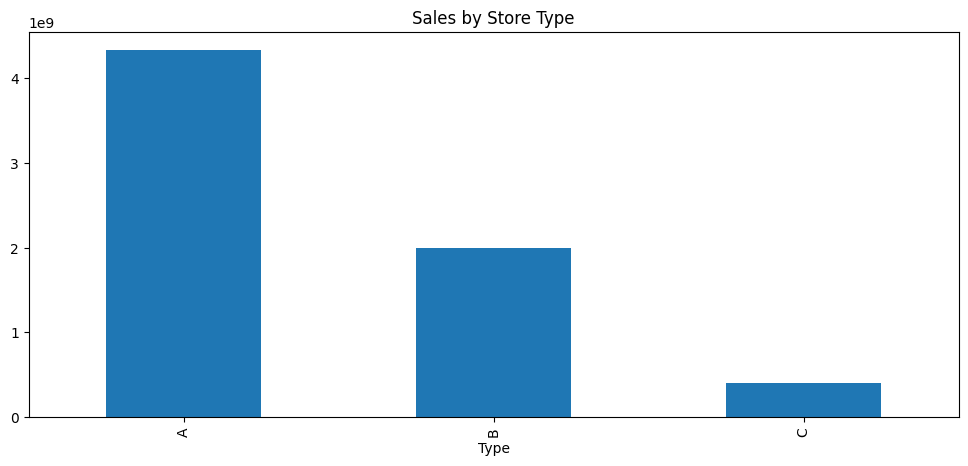

In [12]:
# total sales by store
store_sales = df.groupby(['Store','Type'])['Weekly_Sales'].sum().reset_index()
store_sales.sort_values('Weekly_Sales', ascending=False).head(10)

# aggregate by store Type
type_sales = df.groupby('Type')['Weekly_Sales'].sum()
type_sales.plot(kind='bar', title='Sales by Store Type')
plt.show()


Regional/time evolution (example: store 1)

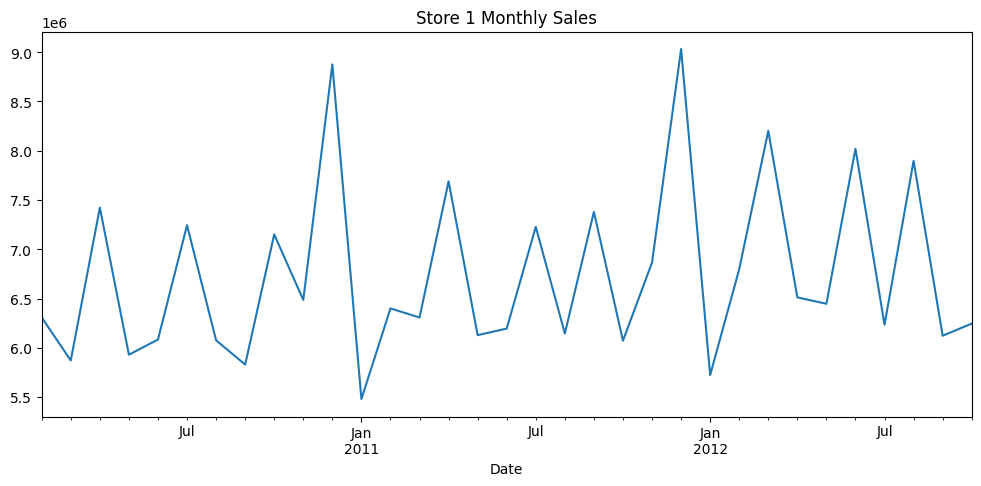

In [13]:
store_id = 1
store_ts = df[df['Store']==store_id].groupby('Date')['Weekly_Sales'].sum().resample('M').sum()
store_ts.plot(title=f'Store {store_id} Monthly Sales')
plt.show()


# Correlations with features (temp, fuel price, CPI)

In [14]:
# aggregate to weekly region-level -- but here we use global sum as example:
agg = df.groupby('Date').agg({'Weekly_Sales':'sum', 'Temperature':'mean', 'Fuel_Price':'mean', 'CPI':'mean', 'Unemployment':'mean'}).dropna()
agg.corr()['Weekly_Sales'].sort_values()


,Weekly_Sales
Temperature,-0.158603
Fuel_Price,-0.056371
Unemployment,0.003443
CPI,0.027008
Weekly_Sales,1.000000


Plot scatter for the most correlated features to inspect linear relations.

# Simple forecasting (bonus)

I’ll do:

*   naive rolling-mean forecast (baseline),
*   Exponential Smoothing (Holt-Winters) with multiplicative seasonality (if variance grows) or additive.

Split the monthly series into train/test:

In [15]:
series = monthly_total.copy()  # monthly_total from earlier
train_size = int(len(series) * 0.8)
train_series = series.iloc[:train_size]
test_series = series.iloc[train_size:]

print("Train months:", len(train_series), "Test months:", len(test_series))


Train months: 26 Test months: 7


Baseline: rolling-mean forecast

In [16]:
# forecast as last 3-month mean repeated
last_mean = train_series.iloc[-3:].mean()
baseline_forecast = pd.Series(last_mean, index=test_series.index)

mae_baseline = mean_absolute_error(test_series, baseline_forecast)
rmse_baseline = np.sqrt(mean_squared_error(test_series, baseline_forecast))
print("Baseline MAE:", mae_baseline, "RMSE:", rmse_baseline)


Baseline MAE: 19960676.281428576 RMSE: 24242525.545282554


Exponential Smoothing (Holt-Winters)

Holt-Winters MAE: 32637339.422773726 RMSE: 36809249.49766542


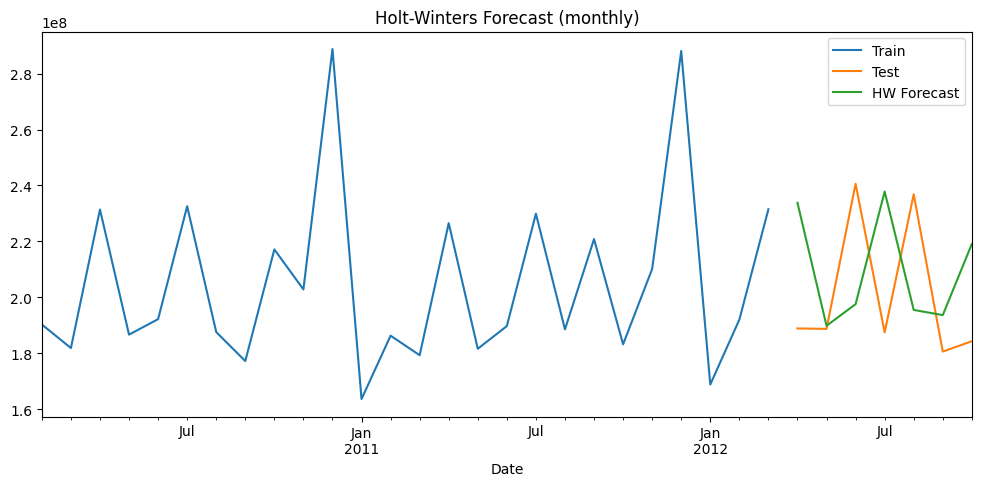

In [17]:
# fit a Holt-Winters model (additive trend and seasonal)
model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit(optimized=True)
hw_forecast = fit.forecast(len(test_series))

# Evaluate
mae_hw = mean_absolute_error(test_series, hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test_series, hw_forecast))
print("Holt-Winters MAE:", mae_hw, "RMSE:", rmse_hw)

# Plot
plt.figure(figsize=(12,5))
train_series.plot(label='Train')
test_series.plot(label='Test')
hw_forecast.plot(label='HW Forecast')
plt.legend()
plt.title('Holt-Winters Forecast (monthly)')
plt.show()


If seasonality is multiplicative (variance scales with level) try seasonal='mul'.

# Model Diagnostics & Interpretation

This step is about evaluating the quality of your forecasting model and understanding how well it performs.

Key tasks:

Calculate error metrics

Measure how far your forecasts are from actual sales using metrics like:

*   MAE (Mean Absolute Error): average absolute difference between forecast and actual.
*   RMSE (Root Mean Squared Error): square root of average squared differences; penalizes large errors more.

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_hw = mean_absolute_error(test_series, hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test_series, hw_forecast))
print("MAE:", mae_hw, "RMSE:", rmse_hw)


MAE: 32637339.422773726 RMSE: 36809249.49766542


Check residuals (forecast errors)

*   Residuals = Actual − Forecast
*   Plot residuals over time to see if they look random.
*   Random residuals → model captured trend & seasonality well.
*   Patterns in residuals → model is missing something (maybe seasonality or trend).

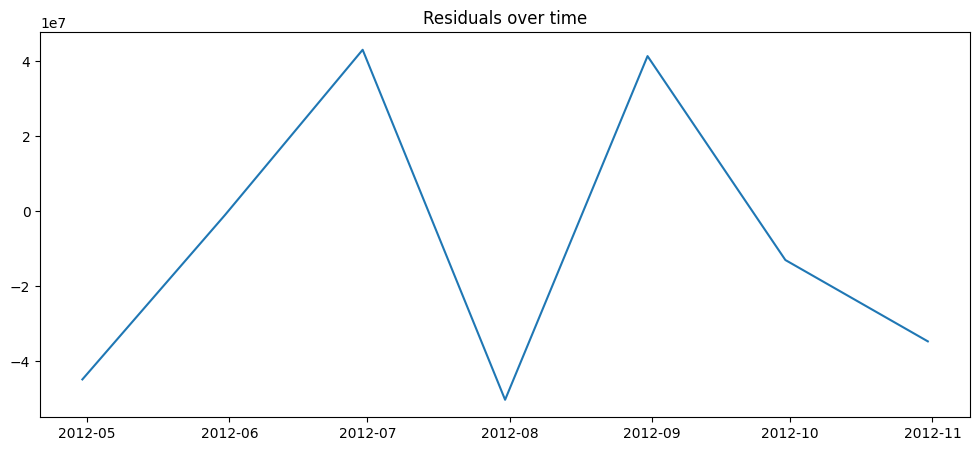

In [19]:
residuals = test_series - hw_forecast
plt.plot(residuals)
plt.title("Residuals over time")
plt.show()
